<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/MobileNet_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
import urllib
import re

In [40]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
original_folder = "/content/drive/My Drive/Colab Notebooks/immagini_originali"

original_images = []
names = []
for file in os.listdir(original_folder):
  family = re.sub("%20|%2520|stemma|.gif", "", file.lower())
  names.append(family)
  file_path = os.path.join(original_folder, file)
  array = np.asarray(Image.open(file_path).convert("RGB"))
  original_images.append(array)

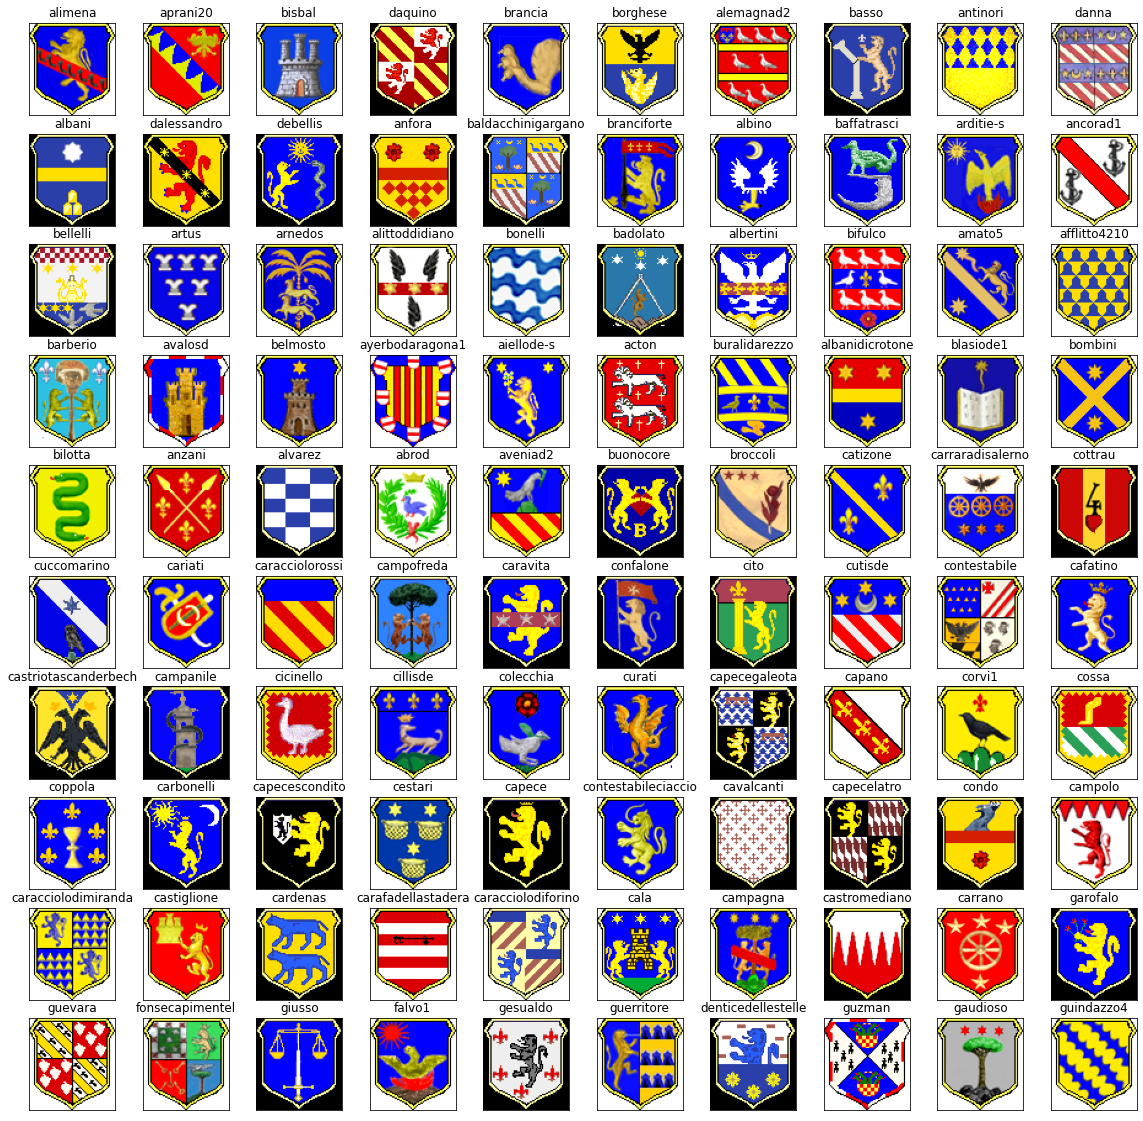

In [69]:
fig, ax_mat = plt.subplots(10, 10, figsize=(20, 20))
axs = np.ravel(ax_mat)
for i in range(100):
  axs[i].imshow(original_images[i])
  axs[i].set(title=names[i], xticks=[], yticks=[])
  
plt.show()

In [0]:
IMG_SIZE = 75 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [0]:

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [0]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [10]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [9]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [11]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [19]:
# Let's take a look at the base model architecture
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [21]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [0]:
with tf.device("/gpu:0"):
  model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
  ])

In [0]:
base_learning_rate = 0.0001
with tf.device("/gpu:0"):
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [35]:
initial_epochs = 10
validation_steps=20

loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 2s 76ms/step - loss: 0.1183 - accuracy: 0.9500


In [36]:
!nvidia-smi
print(tf.test.gpu_device_name())
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Mon Apr 27 09:43:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |   2281MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9298207694254403988, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15859662320429363267
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13871997898763705436
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150726272
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16592149576920852799
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [38]:
with tf.device("/gpu:0"):
  history = model.fit(train_batches,
                      epochs=initial_epochs,
                      validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 79s 136ms/step - loss: 0.0716 - accuracy: 0.9737 - val_loss: 0.0663 - val_accuracy: 0.9751
Epoch 2/10
582/582 [==============================] - 76s 131ms/step - loss: 0.0587 - accuracy: 0.9781 - val_loss: 0.0589 - val_accuracy: 0.9776
Epoch 3/10
582/582 [==============================] - 77s 133ms/step - loss: 0.0528 - accuracy: 0.9800 - val_loss: 0.0546 - val_accuracy: 0.9794
Epoch 4/10
582/582 [==============================] - 77s 133ms/step - loss: 0.0492 - accuracy: 0.9815 - val_loss: 0.0522 - val_accuracy: 0.9802
Epoch 5/10
582/582 [==============================] - 79s 136ms/step - loss: 0.0468 - accuracy: 0.9822 - val_loss: 0.0506 - val_accuracy: 0.9815
Epoch 6/10
582/582 [==============================] - 78s 134ms/step - loss: 0.0451 - accuracy: 0.9836 - val_loss: 0.0494 - val_accuracy: 0.9815
Epoch 7/10
582/582 [==============================] - 78s 133ms/step - loss: 0.0437 - accuracy: 0.9841 - val_loss: 0.0486 - val_ac

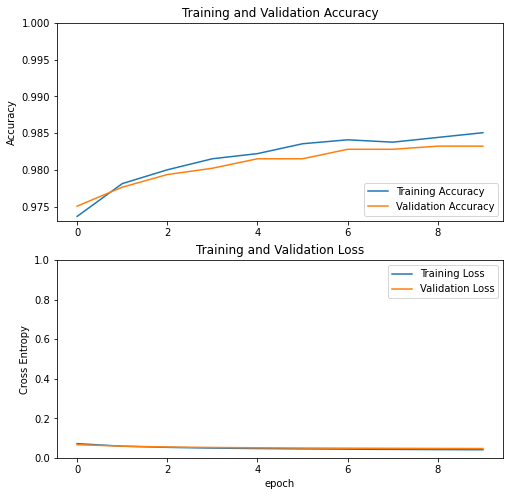

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()